In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

from numpy.linalg import inv, norm
from sklearn import linear_model as sk

from pynwb import NWBHDF5IO
# !pip3 install statsmodels
import statsmodels.api as sm
from statsmodels.genmod.families import Poisson
from statsmodels.genmod.families.links import identity, log
from scipy import signal, interp
from scipy.stats.distributions import chi2

%cd /Users/andrewaoun/Desktop/Fleischmann_Lab/data_sim/Model_V1
# %ls
from glmTry import *
from sklearn.metrics import roc_curve, auc, precision_recall_curve


/Users/andrewaoun/Desktop/Fleischmann_Lab/data_sim/Model_V1


In [2]:
# Load data
io = NWBHDF5IO('/Users/andrewaoun/Desktop/Fleischmann_Lab/data_sim/data.nosync/testing.nwb', 'r')
nwbfile_in = io.read()
flow = nwbfile_in.acquisition['flow'].data.value

In [3]:
# Make stimulus pulses
pulses = np.zeros(10880)
for i in range(80):
    pulses[(136*i+45):(136*i+50)] = 1

In [4]:
# Get relevant data out of NWB file
wheel = nwbfile_in.acquisition['wheel'].data.value
odor = nwbfile_in.stimulus['odor'].data.value

p1 = nwbfile_in.processing['ophys'].data_interfaces['Deconvolved'].roi_response_series['Plane_1'].data.value
p2 = nwbfile_in.processing['ophys'].data_interfaces['Deconvolved'].roi_response_series['Plane_2'].data.value
p3 = nwbfile_in.processing['ophys'].data_interfaces['Deconvolved'].roi_response_series['Plane_3'].data.value

deconvolved = np.vstack((p1,p2,p3))
spikes = np.zeros((deconvolved.shape))

In [5]:
# Deconvolved spikes
for i in range(deconvolved.shape[0]):
    spikes[i, np.where(deconvolved[i, :] > (np.mean(deconvolved[i,:] + 1*np.std(deconvolved[i,:]))))] = 1

In [25]:
# Downsample to 10880
flow = signal.resample(flow, 10880)
print('Flow', len(flow))
wheel[np.isnan(wheel)] = 0
wheel = signal.resample(wheel, 10880)
print('Wheel', len(wheel))

Flow 10880
Wheel 10880


In [7]:
# Set up labels = odors
temp = np.zeros(10880)
for i in range(80):
    temp[i*136:(i+1)*136] = odor[i*30000]
odor = temp
print('Odor', len(odor))

Odor 10880


In [931]:
###### FOR TESTING SIMULATED DATA ######
testing = np.load('/Users/andrewaoun/Desktop/Fleischmann_Lab/data_sim/Model_V1/SIMDATA2.npy')
spikes = testing[19,:,:]

In [9]:
import csv
fill = np.zeros((2,2400000))
with open('/Users/andrewaoun/Desktop/Fleischmann_Lab/data_sim/data.nosync/m8txtrates.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    c = 0
    for row in reader:
        for i in range(1,3,1):
            # print(row)
            fill[i-1,c] = float(row[i])
        c += 1  
print(np.array(fill).shape)
        

(2, 2400000)


In [10]:
######### TESTING #########
flow = fill[0]
wheel = fill[1]
######### TESTING #########

In [26]:
flow.shape

(10880,)

In [27]:
np.max(flow)-np.min(flow)

8.826311457670052

In [56]:
threshold = np.mean(flow)+1.96*np.std(flow)

In [57]:
threshold

4.238606276432427

(0.0, 408.0)

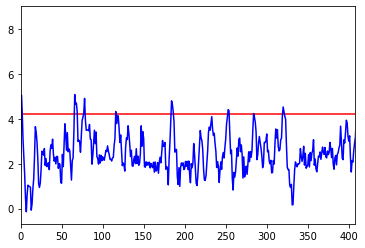

In [58]:
plt.plot(flow, color='b')
plt.hlines(threshold,0,10880, color='r')
plt.xlim(0,136*3)

In [932]:
dt = 30/136
# flowTry = np.array(flow, dtype=np.int32)
# cts, _ = np.histogram(flowTry,np.arange(0,9,1))

rs = []
fs = []
for w in range(15):
    print(w)

    window = w*10
    # window = 80
    i = [[] for i in range(len(cts))]
    r = np.zeros((315,(10880-80)))
    f = np.zeros((10880-80))
    # lo = [[] for i in range(len(flowTry))]


    for i in range(19,20,1):
        for j in range(315):
            for k in range(0,10880-80,1):
                if spikes[j,k] == 1:
                    # print(flowTry[k])
                    # i[flowTry[k]-1].append(j)

                    r[j,k] = np.sum(spikes[j,k:k+window])/window * dt * window
                    f[k] = np.mean(flow[k:k+window])
    rs.append(r)
    fs.append(f)
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [933]:
rn = rs
rn[rs != rs] = 0
fn = fs
fn[fs != fs] = 0

# rn = rs[~np.isnan(rs)]
# fn = fs[~np.isnan(fs)]

In [934]:
rm = np.mean(np.array(rn), axis=0)
fm = np.mean(np.array(fn), axis=0)

In [580]:
# rm = []
# fm = []
# for i in range(8):
#     for (rsval, fsval) in enumerate(rs,fs):
#         rm.append(np.mean(rs,))

In [809]:
print(rm)
print(fm)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.88235294 0.         ... 0.         0.         0.        ]
 [0.         3.63235294 0.         ... 0.         0.         2.        ]]
[0.         2.09924239 2.03284735 ... 1.96540092 1.97308514 1.96948641]


In [810]:
x = np.random.choice(315)
np.corrcoef(fm,rm[x])

array([[1.        , 0.02076057],
       [0.02076057, 1.        ]])

In [876]:
x
#206, 175,195,135,239,118

9

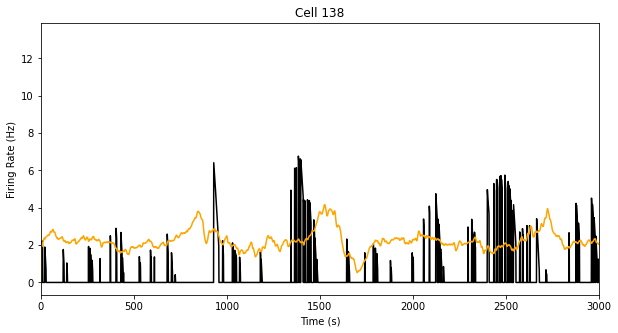

In [938]:
x = np.random.choice(315)
x = 138
fig = plt.figure(figsize=(10,5))
plt.plot(np.arange(10800),rm[x],'k')
plt.plot(np.arange(10800),fm, 'orange')
plt.xlim(0,3000)
plt.title('Cell '+str(x))
plt.xlabel('Time (s)')
plt.ylabel('Firing Rate (Hz)')
plt.show()

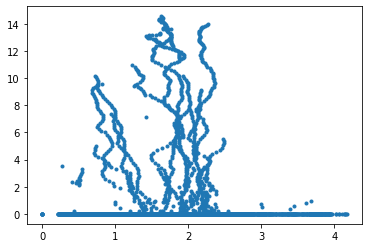

In [892]:
plt.plot(fm,rm[x],'.')

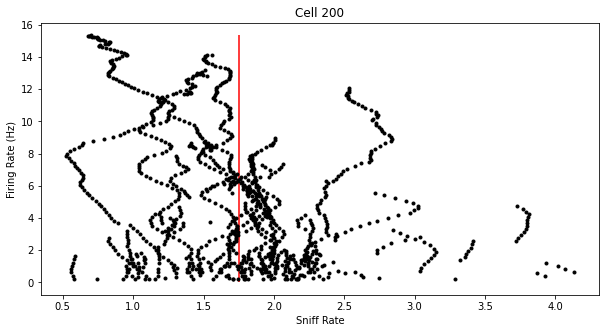

In [939]:
import scipy.stats as s

fig = plt.figure(figsize=(10,5))
x = np.random.choice(315)
x = 138
toplot = rm[x,np.argsort(fm)] 
toplot[toplot == 0] = None
plt.plot(np.sort(fm),toplot, '.',color='k')
# plt.plot(np.sort(f), 'k')
plt.xlabel('Sniff Rate')
plt.ylabel('Firing Rate (Hz)')
# mu, sigma = s.norm.fit(r[x,np.argsort(f)])
# best_fit_line = s.norm.pdf(np.sort(f), mu, sigma)
# plt.plot(np.sort(f), best_fit_line)
# popt, pcov = curve_fit(func, np.sort(f), r[x,np.argsort(f)])
# plt.plot(np.sort(f), func(np.sort(f), *popt), 'r-')
# plt.xlim
plt.vlines(np.mean(np.sort(fm)),0,np.max(toplot[toplot==toplot]),'r')
# plt.vlines(np.mean(np.sort(fm))+np.std(toplot[toplot==toplot]),0,np.max(toplot[toplot==toplot]),'r',lw=0.5,ls=':')
# plt.vlines(np.mean(np.sort(fm))-np.std(toplot[toplot==toplot]),0,np.max(toplot[toplot==toplot]),'r',lw=0.5,ls=':')
plt.title('Cell '+str(x))
plt.show()

In [704]:
np.max(toplot[toplot == toplot])

6.204044117647059

In [345]:
noround = f

In [349]:
np.unique(f).shape

(550,)

In [350]:
np.arange(0,8,0.01).shape

(800,)

In [356]:
np.unique(r[x,np.argsort(f)]).shape

(11,)

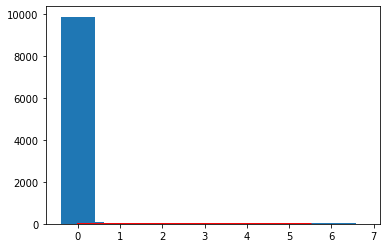

In [359]:
f = np.round(f,2)
c, b = np.histogram(r[x,np.argsort(f)],bins=3000)
c = np.hstack(([0],c))
plt.bar(b,c)


plt.show()

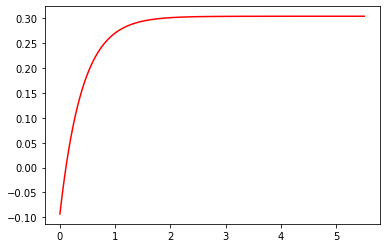

In [360]:
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

popt, pcov = curve_fit(func, np.sort(f), r[x,np.argsort(f)])
plt.plot(np.sort(f), func(np.sort(f), *popt), 'r-')

In [322]:
c

array([   0, 9821,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,  258,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,  249,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,  183,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,  138,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,  105,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,   43,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [69]:
for arr in r:
    print(len(arr))

104173
107046
45854
16381
6692
2057
638
83992


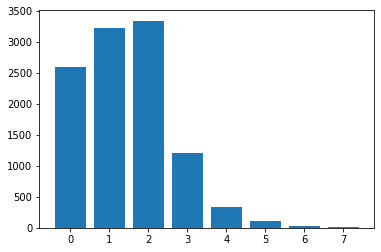

In [76]:
plt.bar(np.arange(8), cts)
plt.show()

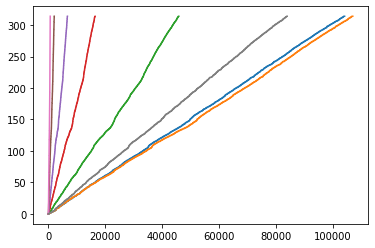

In [70]:
for arr in r:
    plt.plot(arr)
plt.show()

In [39]:
np.max(np.array(flow, dtype=np.int32))-np.min(np.array(flow, dtype=np.int32))

8

In [55]:
cts

array([   0, 2603, 3232, 3346, 1210,  333,  112,   43])

In [61]:
flow

array([1.73601633, 5.071577  , 4.30118009, ..., 0.78055258, 0.38687236,
       0.62764296])